In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import torch as T
import torch.nn as nn
import torch.optim as O
from torch.utils.data import TensorDataset , DataLoader

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import os
import tqdm

In [297]:
df = pd.read_csv("../csvs/Gold/gld_price_data.csv")

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [299]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [300]:
df

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.1800,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.2850,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.1670,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.0530,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.5900,1.557099
...,...,...,...,...,...,...
2285,5/8/2018,2671.919922,124.589996,14.060000,15.5100,1.186789
2286,5/9/2018,2697.790039,124.330002,14.370000,15.5300,1.184722
2287,5/10/2018,2723.070068,125.180000,14.410000,15.7400,1.191753
2288,5/14/2018,2730.129883,124.489998,14.380000,15.5600,1.193118


In [301]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df["Date"] = df["Date"].astype(np.int64) // 10**9


In [302]:
df

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1199232000,1447.160034,84.860001,78.470001,15.1800,1.471692
1,1199318400,1447.160034,85.570000,78.370003,15.2850,1.474491
2,1199404800,1411.630005,85.129997,77.309998,15.1670,1.475492
3,1199664000,1416.180054,84.769997,75.500000,15.0530,1.468299
4,1199750400,1390.189941,86.779999,76.059998,15.5900,1.557099
...,...,...,...,...,...,...
2285,1525737600,2671.919922,124.589996,14.060000,15.5100,1.186789
2286,1525824000,2697.790039,124.330002,14.370000,15.5300,1.184722
2287,1525910400,2723.070068,125.180000,14.410000,15.7400,1.191753
2288,1526256000,2730.129883,124.489998,14.380000,15.5600,1.193118


In [303]:
df

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1199232000,1447.160034,84.860001,78.470001,15.1800,1.471692
1,1199318400,1447.160034,85.570000,78.370003,15.2850,1.474491
2,1199404800,1411.630005,85.129997,77.309998,15.1670,1.475492
3,1199664000,1416.180054,84.769997,75.500000,15.0530,1.468299
4,1199750400,1390.189941,86.779999,76.059998,15.5900,1.557099
...,...,...,...,...,...,...
2285,1525737600,2671.919922,124.589996,14.060000,15.5100,1.186789
2286,1525824000,2697.790039,124.330002,14.370000,15.5300,1.184722
2287,1525910400,2723.070068,125.180000,14.410000,15.7400,1.191753
2288,1526256000,2730.129883,124.489998,14.380000,15.5600,1.193118


In [304]:
df.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

In [305]:
df

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1199232000,1447.160034,84.860001,78.470001,15.1800,1.471692
1,1199318400,1447.160034,85.570000,78.370003,15.2850,1.474491
2,1199404800,1411.630005,85.129997,77.309998,15.1670,1.475492
3,1199664000,1416.180054,84.769997,75.500000,15.0530,1.468299
4,1199750400,1390.189941,86.779999,76.059998,15.5900,1.557099
...,...,...,...,...,...,...
2285,1525737600,2671.919922,124.589996,14.060000,15.5100,1.186789
2286,1525824000,2697.790039,124.330002,14.370000,15.5300,1.184722
2287,1525910400,2723.070068,125.180000,14.410000,15.7400,1.191753
2288,1526256000,2730.129883,124.489998,14.380000,15.5600,1.193118


In [306]:
df.dtypes

Date         int64
SPX        float64
GLD        float64
USO        float64
SLV        float64
EUR/USD    float64
dtype: object

In [307]:
df.corr()

,Date,SPX,GLD,USO,SLV,EUR/USD
Date,1.000000,0.944033,0.209118,-0.782230,-0.174108,-0.794540
SPX,0.944033,1.000000,0.049345,-0.591573,-0.274055,-0.672017
GLD,0.209118,0.049345,1.000000,-0.186360,0.866632,-0.024375
USO,-0.782230,-0.591573,-0.186360,1.000000,0.167547,0.829317
SLV,-0.174108,-0.274055,0.866632,0.167547,1.000000,0.321631
EUR/USD,-0.794540,-0.672017,-0.024375,0.829317,0.321631,1.000000


In [308]:
df["SpxIndex"] = df["EUR/USD"] + df["SPX"]
df["UsoPrice"] = df["EUR/USD"] + df["USO"]
df["SLVPrice"] = df["EUR/USD"] + df["SLV"]

In [309]:
df

,Date,SPX,GLD,USO,SLV,EUR/USD,SpxIndex,UsoPrice,SLVPrice
0,1199232000,1447.160034,84.860001,78.470001,15.1800,1.471692,1448.631726,79.941693,16.651692
1,1199318400,1447.160034,85.570000,78.370003,15.2850,1.474491,1448.634525,79.844494,16.759491
2,1199404800,1411.630005,85.129997,77.309998,15.1670,1.475492,1413.105497,78.785490,16.642492
3,1199664000,1416.180054,84.769997,75.500000,15.0530,1.468299,1417.648353,76.968299,16.521299
4,1199750400,1390.189941,86.779999,76.059998,15.5900,1.557099,1391.747040,77.617097,17.147099
...,...,...,...,...,...,...,...,...,...
2285,1525737600,2671.919922,124.589996,14.060000,15.5100,1.186789,2673.106711,15.246789,16.696789
2286,1525824000,2697.790039,124.330002,14.370000,15.5300,1.184722,2698.974761,15.554722,16.714722
2287,1525910400,2723.070068,125.180000,14.410000,15.7400,1.191753,2724.261821,15.601753,16.931753
2288,1526256000,2730.129883,124.489998,14.380000,15.5600,1.193118,2731.323001,15.573118,16.753118


<Axes: xlabel='SLV', ylabel='EUR/USD'>

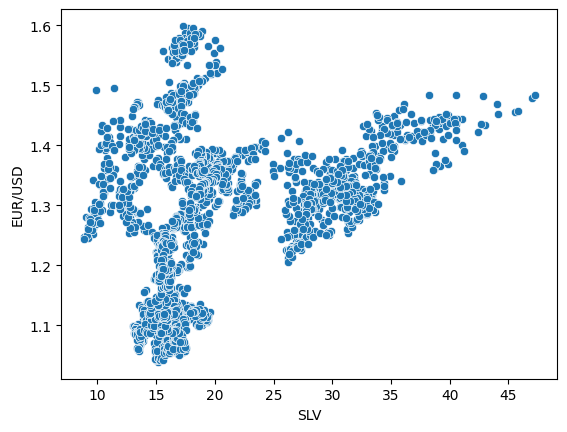

In [310]:
sns.scatterplot(df , x="SLV" ,y = "EUR/USD")

<Axes: xlabel='USO', ylabel='EUR/USD'>

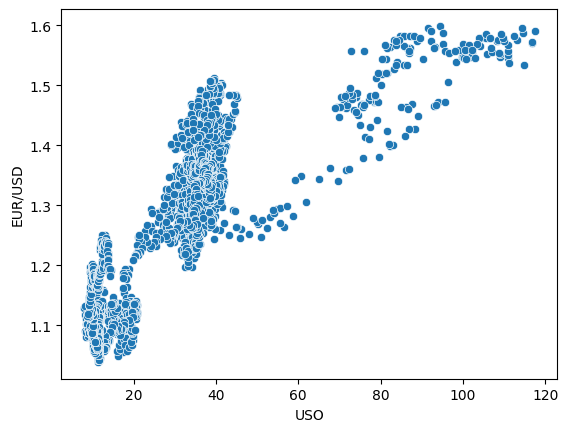

In [311]:
sns.scatterplot(df , x="USO" ,y = "EUR/USD")

<Axes: xlabel='GLD', ylabel='EUR/USD'>

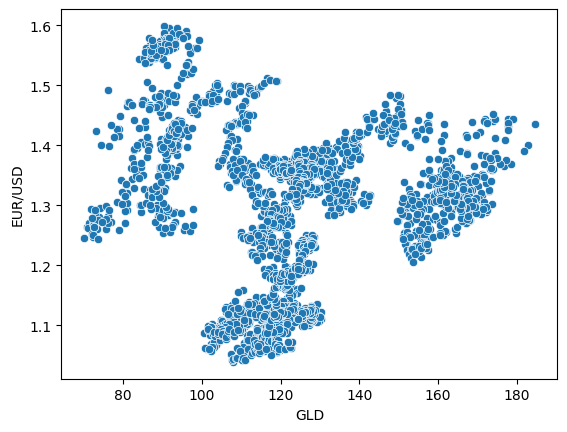

In [312]:
sns.scatterplot(df , x="GLD" ,y = "EUR/USD")

<Axes: xlabel='SPX', ylabel='EUR/USD'>

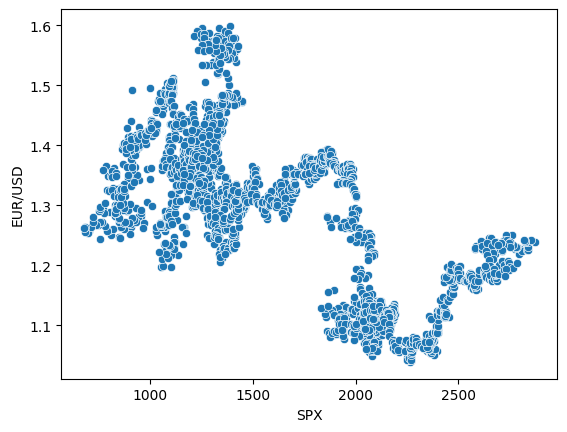

In [313]:
sns.scatterplot(df , x="SPX" ,y = "EUR/USD")

<Axes: xlabel='SPX', ylabel='EUR/USD'>

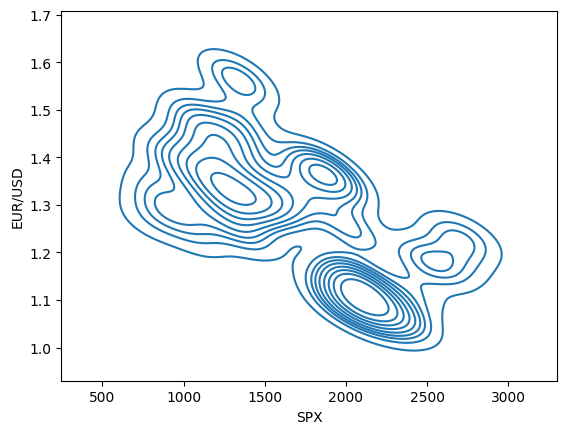

In [314]:
sns.kdeplot(df , x="SPX" ,y = "EUR/USD" )

<Axes: xlabel='USO', ylabel='EUR/USD'>

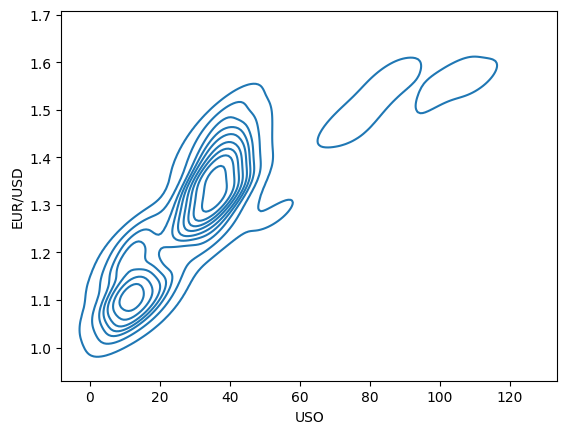

In [315]:
sns.kdeplot(df , x="USO" ,y = "EUR/USD")


<Axes: xlabel='GLD', ylabel='EUR/USD'>

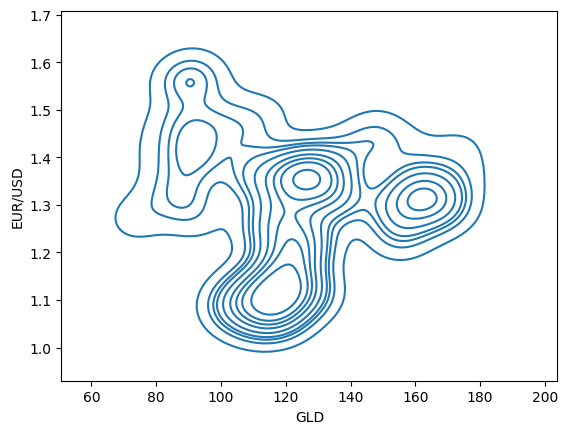

In [316]:
sns.kdeplot(df , x="GLD" ,y = "EUR/USD")

In [317]:
q1 = df.quantile(0.75)
q2 = df.quantile(0.25)
IQR = q1 - q2
print(f"IQR : {IQR} \n")

lowerBound  = q1 - 1.5 * IQR
upperBound  = q1 + 1.5 * IQR

outliner = ((df < lowerBound) | (df > upperBound)).sum()
toData = ((df < lowerBound) | (df > upperBound)).any(axis=1)
print(outliner)

df["Outliner"] = toData

IQR : Date        1.634688e+08
SPX         8.331351e+02
GLD         2.311500e+01
USO         2.344750e+01
SLV         7.312500e+00
EUR/USD     1.986577e-01
SpxIndex    8.329218e+02
UsoPrice    2.365041e+01
SLVPrice    7.482382e+00
dtype: float64 

Date         11
SPX          37
GLD         456
USO         134
SLV         203
EUR/USD     104
SpxIndex     37
UsoPrice    132
SLVPrice    190
dtype: int64


In [318]:
df = df.astype(np.float32)

In [319]:
X = df.drop("EUR/USD" , axis = 1).values
print(X.shape)
X = X.astype(np.float32)
X

(2290, 9)


array([[1.1992320e+09, 1.4471600e+03, 8.4860001e+01, ..., 7.9941696e+01,
        1.6651691e+01, 1.0000000e+00],
       [1.1993184e+09, 1.4471600e+03, 8.5570000e+01, ..., 7.9844498e+01,
        1.6759491e+01, 1.0000000e+00],
       [1.1994048e+09, 1.4116300e+03, 8.5129997e+01, ..., 7.8785492e+01,
        1.6642492e+01, 1.0000000e+00],
       ...,
       [1.5259104e+09, 2.7230701e+03, 1.2518000e+02, ..., 1.5601753e+01,
        1.6931753e+01, 0.0000000e+00],
       [1.5262560e+09, 2.7301299e+03, 1.2449000e+02, ..., 1.5573118e+01,
        1.6753119e+01, 0.0000000e+00],
       [1.5264288e+09, 2.7257800e+03, 1.2254380e+02, ..., 1.5587833e+01,
        1.6636232e+01, 0.0000000e+00]], dtype=float32)

In [320]:
y = df["EUR/USD"].values.reshape(-1,1)
print(y.shape)
y = y.astype(np.float32)
y

(2290, 1)


array([[1.471692],
       [1.474491],
       [1.475492],
       ...,
       [1.191753],
       [1.193118],
       [1.182033]], dtype=float32)

In [321]:
fold = KFold(n_splits= 10 , shuffle=True)
for train , test in fold.split(X ,y ):
    X_train , X_test = X[train] , X[test]
    y_train , y_test = y[train] , y[test]

In [322]:
print(f"  X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"  X_test min: {X_test.min()}, max: {X_test.max()}")
print(f"  y_train min: {y_train.min()}, max: {y_train.max()}")
print(f"  y_test min: {y_test.min()}, max: {y_test.max()}")

  X_train min: 0.0, max: 1526256000.0
  X_test min: 0.0, max: 1526428800.0
  y_train min: 1.0390470027923584, max: 1.5987980365753174
  y_test min: 1.0416990518569946, max: 1.5958130359649658


In [323]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [324]:
print(f"  X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"  X_test min: {X_test.min()}, max: {X_test.max()}")
print(f"  y_train min: {y_train.min()}, max: {y_train.max()}")
print(f"  y_test min: {y_test.min()}, max: {y_test.max()}")

  X_train min: 0.0, max: 1.000000238418579
  X_test min: -0.0002739951014518738, max: 1.0005285739898682
  y_train min: 1.0390470027923584, max: 1.5987980365753174
  y_test min: 1.0416990518569946, max: 1.5958130359649658


In [325]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [326]:
X_train = T.from_numpy(X_train).float()
X_test = T.from_numpy(X_test).float()
y_train = T.from_numpy(y_train).float()
y_test = T.from_numpy(y_test).float()

In [327]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [328]:
y_train.shape[1]

1

In [329]:
print(X_train.shape)
print(X_train.shape[1])

torch.Size([2061, 9])
9


In [330]:
class NN(nn.Module):

    def __init__(self, InDims = X_train.shape[1], OutDims = y_train.shape[1]):
        super().__init__()
        self.ll1 = nn.Linear(InDims , 64)
        self.ll2 = nn.Linear(64 , OutDims)

        self.drop = nn.Dropout(p = (0.3))
        self.activation = nn.PReLU()

    def forward(self , X):

        X = self.activation(self.ll1(X))
        X = self.drop(X)
        X = self.ll2(X)

        return X

class TrainTest():

    def __init__(self):
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.loss = nn.CrossEntropyLoss()
        self.model = NN().to(self.device)
        self.lr = 1e-3
        self.crit = O.Adam(self.model.parameters() , lr = self.lr)
        self.batchSize = 32
        self.epochs = 20

        self.trainData = TensorDataset(X_train , y_train)
        self.testData = TensorDataset(X_test , y_test)

        self.trainLoader = DataLoader(dataset = self.trainData , 
                                     batch_size = self.batchSize,
                                     num_workers= os.cpu_count(),
                                     shuffle = True)

        self.testLoader = DataLoader(dataset = self.testData , 
                                     batch_size = self.batchSize,
                                     num_workers= os.cpu_count())      

    def TrainLoop(self):

        for i in range(self.epochs):
            currentLoss = 0.0

            self.model.train()
            
            with tqdm.tqdm(iterable= self.trainLoader , mininterval=0.1 , disable= False) as Pbar:
                Pbar.set_description(f"Epoch : {i + 1}")
                for X , y in Pbar:
                    X , y = X.to(self.device) , y.to(self.device)
                    
                    logits = self.model(X)
                    loss = self.loss(logits , y)
                    self.crit.zero_grad()
                    loss.backward()
                    self.crit.step()

                    currentLoss += loss.item()
                    Pbar.set_postfix({"Loss": loss.item()})
            print(f"Epoch : {i + 1} / {self.epochs} | Loss : {currentLoss / len(self.trainLoader):.4f}")

    def EvalLoop(self):
        for i in range(self.epochs):
            currentLoss = 0.0
            total_mae = 0.0 
            total_mse = 0.0  
            labels = 0  

            self.model.eval()
            with T.no_grad():  
                with tqdm.tqdm(iterable=self.testLoader, mininterval=0.1, disable=False) as Pbar:
                    Pbar.set_description("Evaluating")
                    for X, y in Pbar:
                        X, y = X.to(self.device), y.to(self.device)
                        logits = self.model(X)
                        loss = self.loss(logits, y)
                        currentLoss += loss.item()
                        mae_batch = metrics.mean_absolute_error(y.cpu(), logits.cpu())
                        mse_batch = metrics.mean_squared_error(y.cpu(), logits.cpu())

                        total_mae += mae_batch * X.size(0)
                        total_mse += mse_batch * X.size(0)
                        labels += X.size(0) 

                        Pbar.set_postfix(loss=currentLoss / (labels + 1e-8),
                                          mean_absolute_error=total_mae / (labels + 1e-8),
                                          mean_squared_error=total_mse / (labels + 1e-8))

In [331]:
TrainTest().TrainLoop()
TrainTest().EvalLoop()

Epoch : 1: 100%|██████████| 65/65 [00:05<00:00, 12.73it/s, Loss=-]


Epoch : 1 / 20 | Loss : 0.0000


Epoch : 2: 100%|██████████| 65/65 [00:04<00:00, 13.47it/s, Loss=-]


Epoch : 2 / 20 | Loss : 0.0000


Epoch : 3: 100%|██████████| 65/65 [00:05<00:00, 12.34it/s, Loss=-]


Epoch : 3 / 20 | Loss : 0.0000


Epoch : 4: 100%|██████████| 65/65 [00:04<00:00, 13.42it/s, Loss=-]


Epoch : 4 / 20 | Loss : 0.0000


Epoch : 5: 100%|██████████| 65/65 [00:06<00:00, 10.75it/s, Loss=-]


Epoch : 5 / 20 | Loss : 0.0000


Epoch : 6: 100%|██████████| 65/65 [00:05<00:00, 11.53it/s, Loss=-]


Epoch : 6 / 20 | Loss : 0.0000


Epoch : 7: 100%|██████████| 65/65 [00:04<00:00, 14.17it/s, Loss=-]


Epoch : 7 / 20 | Loss : 0.0000


Epoch : 8: 100%|██████████| 65/65 [00:05<00:00, 12.96it/s, Loss=-]


Epoch : 8 / 20 | Loss : 0.0000


Epoch : 9: 100%|██████████| 65/65 [00:04<00:00, 13.62it/s, Loss=-]


Epoch : 9 / 20 | Loss : 0.0000


Epoch : 10: 100%|██████████| 65/65 [00:04<00:00, 13.46it/s, Loss=-]


Epoch : 10 / 20 | Loss : 0.0000


Epoch : 11: 100%|██████████| 65/65 [00:04<00:00, 13.32it/s, Loss=-]


Epoch : 11 / 20 | Loss : 0.0000


Epoch : 12: 100%|██████████| 65/65 [00:04<00:00, 13.94it/s, Loss=-]


Epoch : 12 / 20 | Loss : 0.0000


Epoch : 13: 100%|██████████| 65/65 [00:05<00:00, 12.99it/s, Loss=-]


Epoch : 13 / 20 | Loss : 0.0000


Epoch : 14: 100%|██████████| 65/65 [00:05<00:00, 12.08it/s, Loss=-]


Epoch : 14 / 20 | Loss : 0.0000


Epoch : 15: 100%|██████████| 65/65 [00:04<00:00, 13.19it/s, Loss=-]


Epoch : 15 / 20 | Loss : 0.0000


Epoch : 16: 100%|██████████| 65/65 [00:05<00:00, 12.52it/s, Loss=-]


Epoch : 16 / 20 | Loss : 0.0000


Epoch : 17: 100%|██████████| 65/65 [00:05<00:00, 11.42it/s, Loss=-]


Epoch : 17 / 20 | Loss : 0.0000


Epoch : 18: 100%|██████████| 65/65 [00:04<00:00, 13.13it/s, Loss=-]


Epoch : 18 / 20 | Loss : 0.0000


Epoch : 19: 100%|██████████| 65/65 [00:05<00:00, 12.20it/s, Loss=-]


Epoch : 19 / 20 | Loss : 0.0000


Epoch : 20: 100%|██████████| 65/65 [00:05<00:00, 12.03it/s, Loss=-]


Epoch : 20 / 20 | Loss : 0.0000


Evaluating: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s, loss=0, mean_absolute_error=1.3, mean_squared_error=1.71] 
